Using device: cpu
Files already downloaded and verified
Epoch [1/300] Loss: 12.5028
Epoch [2/300] Loss: 14.6102
Epoch [3/300] Loss: 20.6512
Epoch [4/300] Loss: 9.8733
Epoch [5/300] Loss: 11.0423
Epoch [6/300] Loss: 24.0108
Epoch [7/300] Loss: 6.6478
Epoch [8/300] Loss: 14.9135
Epoch [9/300] Loss: 18.9013
Epoch [10/300] Loss: 26.0211
Epoch [11/300] Loss: 6.0447
Epoch [12/300] Loss: 16.1938
Epoch [13/300] Loss: 15.6321
Epoch [14/300] Loss: 26.4820
Epoch [15/300] Loss: 17.0154
Epoch [16/300] Loss: 15.6224
Epoch [17/300] Loss: 13.9928
Epoch [18/300] Loss: 17.9997
Epoch [19/300] Loss: 14.8102
Epoch [20/300] Loss: 7.2563
Epoch [21/300] Loss: 11.0750
Epoch [22/300] Loss: 15.2643
Epoch [23/300] Loss: 10.8396
Epoch [24/300] Loss: 15.8559
Epoch [25/300] Loss: 11.4026
Epoch [26/300] Loss: 14.8976
Epoch [27/300] Loss: 13.9543
Epoch [28/300] Loss: 8.9608
Epoch [29/300] Loss: 17.2696
Epoch [30/300] Loss: 11.8028
Epoch [31/300] Loss: 17.3819
Epoch [32/300] Loss: 8.9648
Epoch [33/300] Loss: 11.9559
Ep

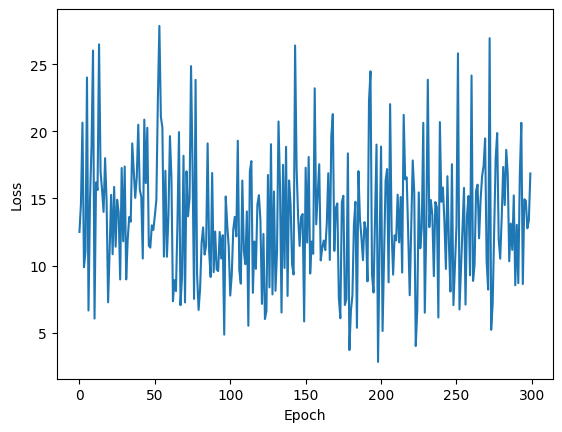

In [9]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from PIL import Image
import io
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import numpy as np

# DCT转换函数修正版
# 修正版DCT转换函数（支持批量处理）
def img_to_dct(batch_img):
    """将批量空域图像转换为DCT系数矩阵"""
    batch_dct = []
    for img in batch_img:
        # 确保输入为单张图像 (C, H, W)
        img = img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
        img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
        dct_channels = [
            cv2.dct((img[:, :, i].astype(np.float32) - 128) / 255)
            for i in range(3)
        ]
        dct_img = np.stack(dct_channels, axis=0)  # (C, H, W)
        batch_dct.append(torch.tensor(dct_img))
    
    return torch.stack(batch_dct).to(device)  # (B, C, H, W)

def dct_to_img(batch_dct):
    """将批量DCT系数矩阵转换回空域图像"""
    batch_img = []
    for dct_img in batch_dct:
        # 确保输入为单张DCT系数 (C, H, W)
        dct_img = dct_img.permute(1, 2, 0).cpu().numpy() * 255  # (H, W, C)
        
        idct_channels = [
            cv2.idct(dct_img[:, :, i]) * 255 + 128
            for i in range(3)
        ]
        reconstructed = cv2.cvtColor(
            np.stack(idct_channels, axis=-1).astype(np.uint8),
            cv2.COLOR_YCrCb2RGB
        )
        batch_img.append(torch.tensor(reconstructed).permute(2, 0, 1).float() / 255)
    
    return torch.stack(batch_img).to(device)  # (B, C, H, W)

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CIFAR-10数据集加载
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# 数据集拆分
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# JPEG压缩函数修正版
def jpeg_compress(x, quality):
    """批量JPEG压缩处理"""
    compressed_images = []
    for img in x:
        spatial_img = dct_to_img(img.unsqueeze(0))[0]  # 处理单张图像
        pil_img = torchvision.transforms.ToPILImage()(spatial_img.cpu())
        buffer = io.BytesIO()
        pil_img.save(buffer, "JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_tensor = torchvision.transforms.ToTensor()(compressed_img)
        compressed_dct = img_to_dct(compressed_tensor.unsqueeze(0))[0]  # 保持维度一致
        compressed_images.append(compressed_dct)
    return torch.stack(compressed_images).to(device)

# 修正的UNet结构
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        # 下采样
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # 上采样
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # 关键修改点
        self.dec1 = DoubleConv(128, 64)
        
        # 输出层
        self.out_conv = nn.Sequential(
            nn.Conv2d(64, 3, 1),
            nn.Tanh()
        )
        
        # 时间嵌入
        self.time_embed = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t.float().view(-1,1)).view(-1,512,1,1)
        
        # Encoder
        x1 = self.enc1(x)        # 32x32
        x2 = self.enc2(self.pool(x1))  # 16x16
        x3 = self.enc3(self.pool(x2))  # 8x8
        
        # Bottleneck
        x = self.bottleneck(self.pool(x3)) + t_embed  # 4x4
        
        # Decoder
        x = self.up3(x)          # 8x8
        x = torch.cat([F.interpolate(x3, x.shape[2:]), x], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)          # 16x16
        x = torch.cat([F.interpolate(x2, x.shape[2:]), x], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)          # 32x32
        x = torch.cat([F.interpolate(x1, x.shape[2:]), x], dim=1)
        x = self.dec1(x)
        
        return self.out_conv(x)

# 训练参数设置
net = UNetDenoiser().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100)

# 预定义噪声参数
beta_t = torch.linspace(1e-4, 0.02, 100).to(device)
alpha_t_list = 1 - beta_t
alpha_bar_t = torch.cumprod(alpha_t_list, dim=0)  # 预计算累积乘积

# 训练循环修正版
n_epochs = 300
best_loss = float('inf')
loss_history = []

for epoch in range(n_epochs):
    net.train()
    epoch_loss = 0
    for x0, _ in train_dataloader:
        x0 = x0.to(device)  # (B, C, H, W)
        x0_dct = img_to_dct(x0)  # (B, C, H, W)
        
        qf = random.randint(1, 100)
        xt = jpeg_compress(x0_dct, qf)  # (B, C, H, W)
        
        t = torch.full((x0.size(0),), 100 - qf, device=device)
        alpha_bar = alpha_bar_t[t].view(-1, 1, 1, 1)
        
        noise = (xt - torch.sqrt(alpha_bar) * x0_dct) / torch.sqrt(1 - alpha_bar + 1e-6)
        pred_noise = net(xt, t.float())  # (B, C, H, W)
        
        # 确保输出与目标维度一致
        loss = loss_fn(pred_noise, noise)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    # 学习率调整
    scheduler.step()
    
    # 保存模型
    avg_loss = epoch_loss/len(train_dataloader)
    loss_history.append(avg_loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(net.state_dict(), "best_dct_denoiser.pth")
    
    print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {avg_loss:.4f}")

# 绘制损失曲线
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('dct_loss.png')

Using device: cpu
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1: SSIM (Original vs Compressed) = 0.7977, SSIM (Original vs Denoised) = 0.7307, PSNR (Original vs Compressed) = 25.72 dB, PSNR (Original vs Denoised) = 14.05 dB


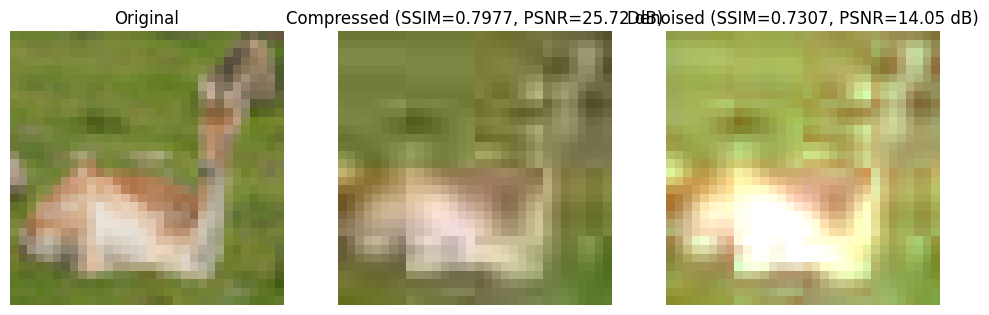

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 2: SSIM (Original vs Compressed) = 0.8782, SSIM (Original vs Denoised) = 0.7962, PSNR (Original vs Compressed) = 23.59 dB, PSNR (Original vs Denoised) = 12.84 dB


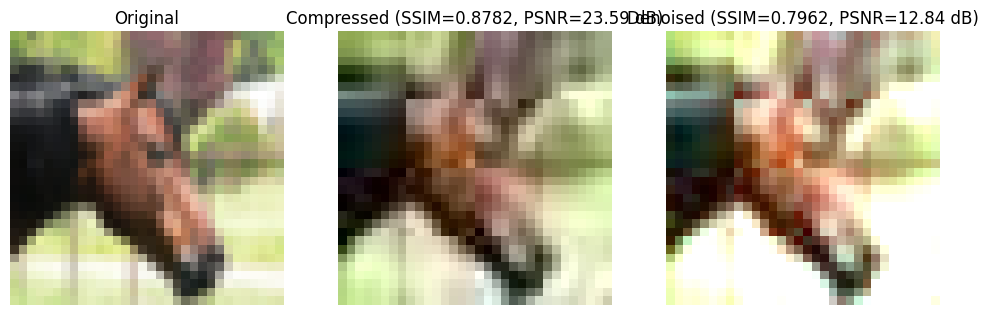

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 3: SSIM (Original vs Compressed) = 0.8472, SSIM (Original vs Denoised) = 0.7737, PSNR (Original vs Compressed) = 25.28 dB, PSNR (Original vs Denoised) = 12.55 dB


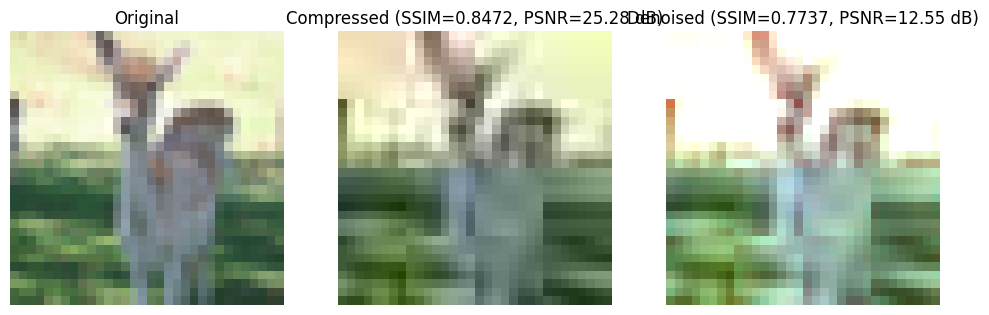

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 4: SSIM (Original vs Compressed) = 0.8510, SSIM (Original vs Denoised) = 0.7851, PSNR (Original vs Compressed) = 26.74 dB, PSNR (Original vs Denoised) = 13.23 dB


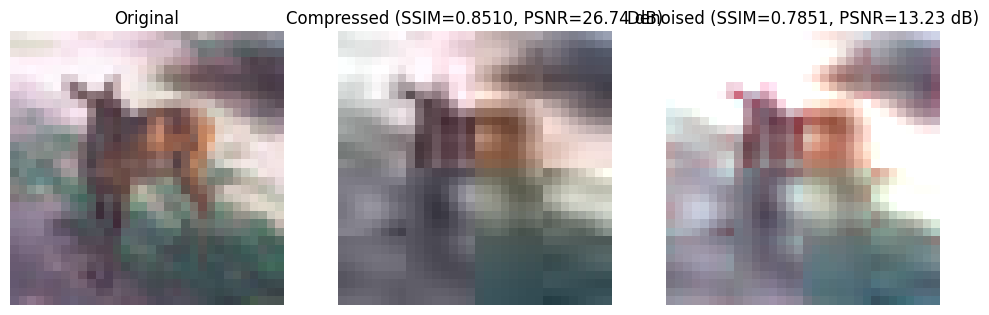

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 5: SSIM (Original vs Compressed) = 0.8965, SSIM (Original vs Denoised) = 0.8270, PSNR (Original vs Compressed) = 26.59 dB, PSNR (Original vs Denoised) = 15.02 dB


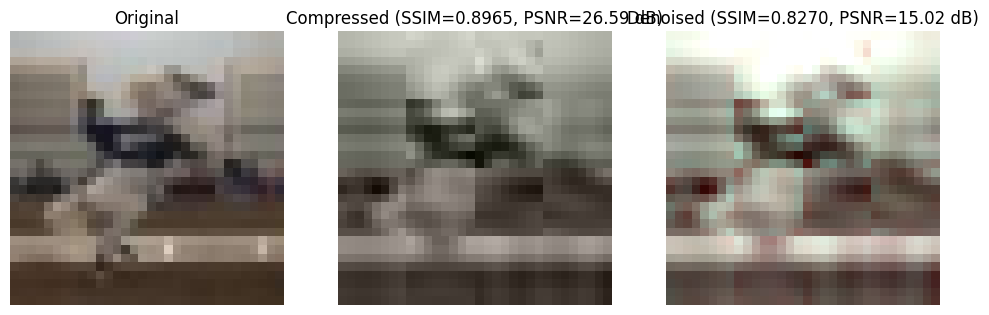

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 6: SSIM (Original vs Compressed) = 0.7972, SSIM (Original vs Denoised) = 0.7269, PSNR (Original vs Compressed) = 24.38 dB, PSNR (Original vs Denoised) = 12.81 dB


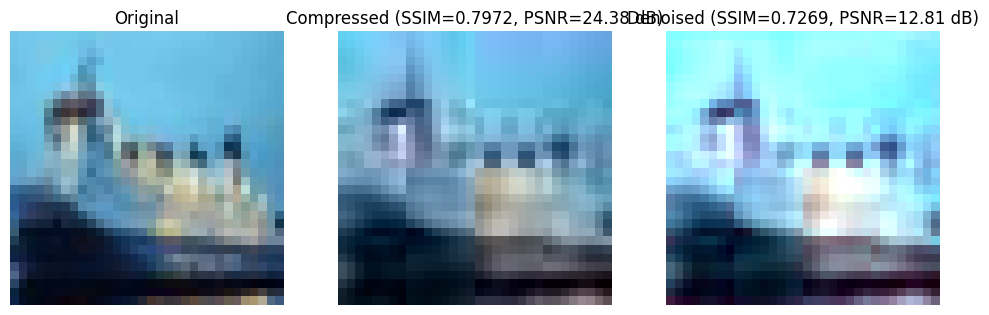

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 7: SSIM (Original vs Compressed) = 0.8472, SSIM (Original vs Denoised) = 0.7683, PSNR (Original vs Compressed) = 22.53 dB, PSNR (Original vs Denoised) = 13.90 dB


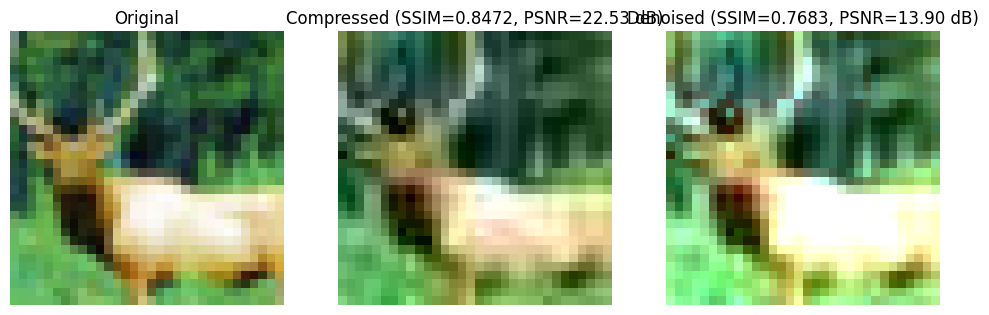

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 8: SSIM (Original vs Compressed) = 0.8743, SSIM (Original vs Denoised) = 0.7969, PSNR (Original vs Compressed) = 26.83 dB, PSNR (Original vs Denoised) = 18.33 dB


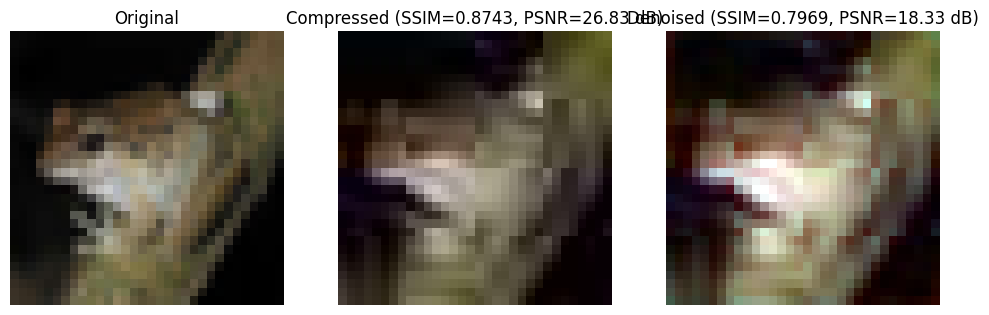

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 9: SSIM (Original vs Compressed) = 0.8914, SSIM (Original vs Denoised) = 0.8088, PSNR (Original vs Compressed) = 26.02 dB, PSNR (Original vs Denoised) = 11.75 dB


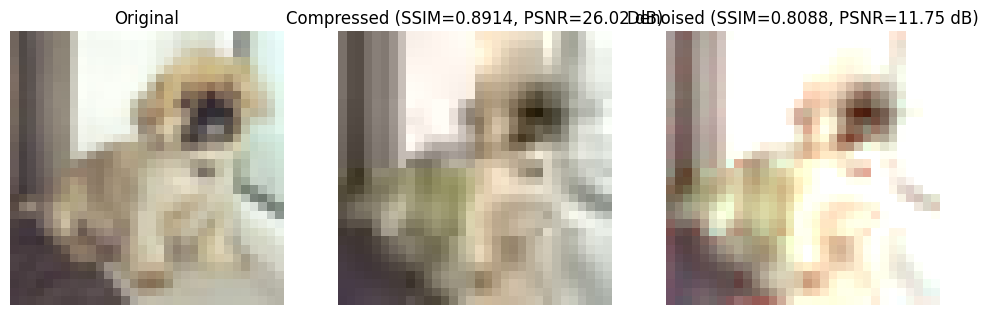

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 10: SSIM (Original vs Compressed) = 0.8804, SSIM (Original vs Denoised) = 0.7990, PSNR (Original vs Compressed) = 22.68 dB, PSNR (Original vs Denoised) = 12.00 dB


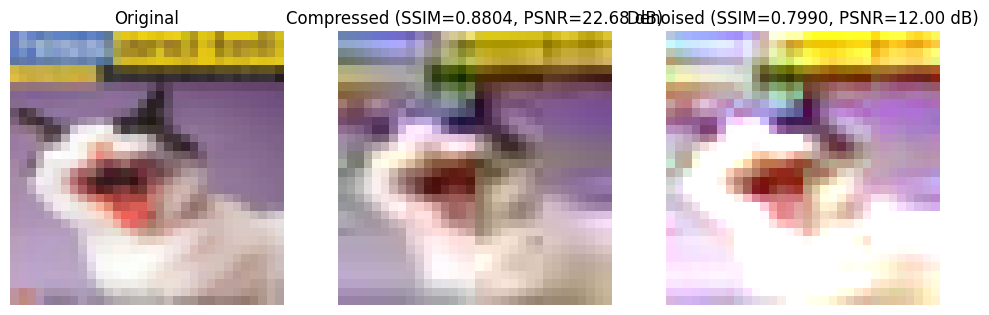

Average SSIM (Original vs Compressed): 0.8561
Average SSIM (Original vs Denoised): 0.7813
Average PSNR (Original vs Compressed): 25.04 dB
Average PSNR (Original vs Denoised): 13.65 dB


In [12]:
import torch
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import io
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import torch.nn.functional as F

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 下載 CIFAR-10 測試資料集
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# 修正的UNet结构
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        # 下采样
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # 上采样
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # 关键修改点
        self.dec1 = DoubleConv(128, 64)
        
        # 输出层
        self.out_conv = nn.Sequential(
            nn.Conv2d(64, 3, 1),
            nn.Tanh()
        )
        
        # 时间嵌入
        self.time_embed = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t.float().view(-1,1)).view(-1,512,1,1)
        
        # Encoder
        x1 = self.enc1(x)        # 32x32
        x2 = self.enc2(self.pool(x1))  # 16x16
        x3 = self.enc3(self.pool(x2))  # 8x8
        
        # Bottleneck
        x = self.bottleneck(self.pool(x3)) + t_embed  # 4x4
        
        # Decoder
        x = self.up3(x)          # 8x8
        x = torch.cat([F.interpolate(x3, x.shape[2:]), x], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)          # 16x16
        x = torch.cat([F.interpolate(x2, x.shape[2:]), x], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)          # 32x32
        x = torch.cat([F.interpolate(x1, x.shape[2:]), x], dim=1)
        x = self.dec1(x)
        
        return self.out_conv(x)



# 加載最佳模型
net = UNetDenoiser().to(device)
net.load_state_dict(torch.load("best_dct_denoiser.pth"))
net.eval()

# 設置 DDPM 相關參數
T = 100
beta_t = torch.linspace(1e-4, 0.02, T).to(device)
alpha_t_list = 1 - beta_t

def ddpm_inference(model, x0, T=80):
    # 轉換到頻域
    xt = jpeg_compress(x0, quality=20)  # 壓縮後的影像
    freq_xt = torch.fft.fft2(xt)  # 轉換到頻域
    magnitude = torch.abs(freq_xt)  # 取得頻譜幅度
    phase = torch.angle(freq_xt)  # 取得相位

    for t in range(T, 0, -1):
        t_tensor = torch.tensor([t], device=device, dtype=torch.float32).view(1, 1)
        
        # 讓模型處理頻譜的 magnitude
        predicted_noise = model(magnitude, t_tensor)
        
        # DDPM 更新步驟
        alpha_t = alpha_t_list[t - 1]
        alpha_bar_t = torch.prod(alpha_t_list[:t])
        magnitude = (1 / torch.sqrt(alpha_t)) * (magnitude - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise)
    
    # 恢復到空域
    denoised_freq = magnitude * torch.exp(1j * phase)  # 結合處理後的 magnitude 與原始 phase
    x_denoised = torch.fft.ifft2(denoised_freq).real  # 轉回空域
    
    return x_denoised

# 測試與視覺化
# 計算 PSNR
def psnr(img1, img2, data_range=1.0):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')  # 無限大代表完全相同
    return 10 * torch.log10((data_range ** 2) / mse)

# 測試與視覺化
ssim_compressed_total = 0
ssim_denoised_total = 0
psnr_compressed_total = 0
psnr_denoised_total = 0
num_images = 10  # 測試 10 張圖片

for i, (x0, _) in enumerate(test_dataloader):
    x0 = x0.to(device)
    x_compressed = jpeg_compress(x0, quality=20)
    x_denoised = ddpm_inference(net, x0).detach()
    
    # 計算 SSIM
    ssim_compressed = ssim(x0, x_compressed, data_range=1.0)
    ssim_denoised = ssim(x0, x_denoised, data_range=1.0)

    # 計算 PSNR
    psnr_compressed = psnr(x0, x_compressed, data_range=1.0)
    psnr_denoised = psnr(x0, x_denoised, data_range=1.0)
    
    ssim_compressed_total += ssim_compressed.item()
    ssim_denoised_total += ssim_denoised.item()
    psnr_compressed_total += psnr_compressed.item()
    psnr_denoised_total += psnr_denoised.item()
    
    print(f"Image {i+1}: "
          f"SSIM (Original vs Compressed) = {ssim_compressed:.4f}, "
          f"SSIM (Original vs Denoised) = {ssim_denoised:.4f}, "
          f"PSNR (Original vs Compressed) = {psnr_compressed:.2f} dB, "
          f"PSNR (Original vs Denoised) = {psnr_denoised:.2f} dB")

    # 顯示圖片
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(x0.cpu().squeeze().permute(1, 2, 0))
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    axes[1].imshow(x_compressed.cpu().squeeze().permute(1, 2, 0))
    axes[1].set_title(f"Compressed (SSIM={ssim_compressed:.4f}, PSNR={psnr_compressed:.2f} dB)")
    axes[1].axis("off")
    
    axes[2].imshow(x_denoised.cpu().squeeze().permute(1, 2, 0))
    axes[2].set_title(f"Denoised (SSIM={ssim_denoised:.4f}, PSNR={psnr_denoised:.2f} dB)")
    axes[2].axis("off")
    
    plt.show()
    
    if i >= num_images - 1:
        break

# 計算平均 SSIM 和 PSNR
avg_ssim_compressed = ssim_compressed_total / num_images
avg_ssim_denoised = ssim_denoised_total / num_images
avg_psnr_compressed = psnr_compressed_total / num_images
avg_psnr_denoised = psnr_denoised_total / num_images

print(f"Average SSIM (Original vs Compressed): {avg_ssim_compressed:.4f}")
print(f"Average SSIM (Original vs Denoised): {avg_ssim_denoised:.4f}")
print(f"Average PSNR (Original vs Compressed): {avg_psnr_compressed:.2f} dB")
print(f"Average PSNR (Original vs Denoised): {avg_psnr_denoised:.2f} dB")

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. 数据准备 ---
class CIFAR10DCTDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, download=True):
        super().__init__(
            root=root,
            train=train,
            download=download,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        )
        
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        return img, label

# 加载数据集
dataset = CIFAR10DCTDataset(root="./data", train=True)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# --- 2. DCT处理模块 ---
class DCTProcessor:
    def __init__(self, device):
        self.device = device
        # JPEG标准量化表
        self.quant_y = torch.tensor([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ], dtype=torch.float32, device=device)

        self.quant_c = torch.tensor([
            [17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]
        ], dtype=torch.float32, device=device)

    def _dct_8x8(self, block):
        """计算8x8块的DCT变换"""
        # 使用torch.rfft实现DCT
        block = block - 128  # JPEG中心化
        dct = torch.zeros_like(block)
        for u in range(8):
            for v in range(8):
                cu = 1.0 / np.sqrt(2) if u == 0 else 1.0
                cv = 1.0 / np.sqrt(2) if v == 0 else 1.0
                s = 0.0
                for x in range(8):
                    for y in range(8):
                        s += block[x, y] * torch.cos((2 * x + 1) * u * np.pi / 16) * torch.cos((2 * y + 1) * v * np.pi / 16)
                dct[u, v] = 0.25 * cu * cv * s
        return dct

    def _idct_8x8(self, block):
        """计算8x8块的IDCT变换"""
        # 使用torch.rfft实现IDCT
        output = torch.zeros_like(block)
        for x in range(8):
            for y in range(8):
                s = 0.0
                for u in range(8):
                    for v in range(8):
                        cu = 1.0 / np.sqrt(2) if u == 0 else 1.0
                        cv = 1.0 / np.sqrt(2) if v == 0 else 1.0
                        s += cu * cv * block[u, v] * torch.cos((2 * x + 1) * u * np.pi / 16) * torch.cos((2 * y + 1) * v * np.pi / 16)
                output[x, y] = 0.25 * s + 128  # JPEG反中心化
        return output

    def jpeg_compress(self, images, quality=50):
        """模拟JPEG压缩过程"""
        batch_size, channels, height, width = images.shape
        assert height % 8 == 0 and width % 8 == 0, "Image dimensions must be multiples of 8"
        
        # 质量因子调整量化表
        if quality < 50:
            scale = 50 / quality
        else:
            scale = 2 - quality / 50
            
        quant_y = torch.clamp((self.quant_y * scale).round(), min=1)
        quant_c = torch.clamp((self.quant_c * scale).round(), min=1)
        
        compressed = torch.zeros_like(images)
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(0, height, 8):
                    for j in range(0, width, 8):
                        # 提取8x8块
                        block = images[b, c, i:i+8, j:j+8]
                        
                        # DCT变换
                        dct_block = self._dct_8x8(block)
                        
                        # 量化
                        quant_table = quant_y if c == 0 else quant_c
                        quantized = torch.round(dct_block / quant_table)
                        
                        # 反量化
                        dequantized = quantized * quant_table
                        
                        # IDCT变换
                        reconstructed = self._idct_8x8(dequantized)
                        
                        # 存储结果
                        compressed[b, c, i:i+8, j:j+8] = reconstructed
        
        return compressed

# --- 3. 网络架构 ---
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        half_dim = dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        self.register_buffer("emb", emb)

    def forward(self, t):
        emb = t[:, None] * self.emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class DCTDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 时间嵌入
        self.time_mlp = nn.Sequential(
            TimeEmbedding(256),
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Linear(256, 256),
        )
        
        # 下采样路径
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.GroupNorm(16, 128),
            nn.GELU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(16, 128),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        
        # 中间层
        self.mid = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.GroupNorm(32, 256),
            nn.GELU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.GroupNorm(32, 256),
            nn.GELU(),
        )
        
        # 上采样路径
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(16, 128),
            nn.GELU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(16, 128),
            nn.GELU(),
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
        )
        
        # 输出层
        self.out = nn.Conv2d(64, 3, 3, padding=1)
        
    def forward(self, x, t):
        # 时间嵌入
        t_emb = self.time_mlp(t)
        
        # 下采样
        h1 = self.down1(x)
        h2 = self.down2(h1)
        
        # 中间层
        h = self.mid(h2)
        
        # 加入时间信息
        t_emb = t_emb.view(-1, 256, 1, 1).expand(-1, -1, h.shape[2], h.shape[3])
        # 上采样
        h = self.up1(h + t_emb)
        h = self.up2(h + h1)
        
        # 输出
        return self.out(h)

# --- 4. 训练配置 ---
def get_quality_schedule(t, mode='cosine'):
    """质量调度函数"""
    if mode == 'cosine':
        return 100 - 95 * (torch.cos(t * torch.pi / 2) ** 2)
    else:  # linear
        return 100 - 95 * t

class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()
        
    def forward(self, pred, target):
        # 基础MSE损失
        mse_loss = self.mse(pred, target)
        
        # 高频损失(计算拉普拉斯梯度差异)
        lap_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], 
                                dtype=torch.float32, device=device).view(1,1,3,3)
        pred_lap = F.conv2d(pred, lap_kernel.expand(3,1,3,3), groups=3)
        target_lap = F.conv2d(target, lap_kernel.expand(3,1,3,3), groups=3)
        hf_loss = self.l1(pred_lap, target_lap)
        
        return mse_loss + 0.5 * hf_loss

def train_model():
    # 初始化
    model = DCTDenoiser().to(device)
    dct_processor = DCTProcessor(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
    criterion = HybridLoss()
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    # 训练循环
    for epoch in range(300):
        model.train()
        epoch_train_loss = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/300")
        for x0, _ in pbar:
            x0 = x0.to(device)
            
            # 随机采样时间步和质量因子
            t = torch.rand(x0.size(0), device=device)  # [0,1)
            quality = get_quality_schedule(t)  # [5,100]
            
            # 生成压缩图像
            xt = dct_processor.jpeg_compress(x0, quality)
            
            # 模型预测
            pred = model(xt, t*100)  # 映射到[0,100]
            
            # 计算损失
            loss = criterion(pred, x0)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        scheduler.step()
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 验证
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x0, _ in val_loader:
                x0 = x0.to(device)
                t = torch.rand(x0.size(0), device=device)
                quality = get_quality_schedule(t)
                xt = dct_processor.jpeg_compress(x0, quality)
                pred = model(xt, t*100)
                loss = criterion(pred, x0)
                epoch_val_loss += loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_dct_denoiser.pth")
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.close()

# --- 5. 测试和可视化 ---
def visualize_results(model_path="best_dct_denoiser.pth"):
    model = DCTDenoiser().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    dct_processor = DCTProcessor(device)
    
    # 获取测试数据
    test_dataset = CIFAR10DCTDataset(root="./data", train=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    x0, _ = next(iter(test_loader))
    x0 = x0.to(device)
    
    # 生成不同压缩质量的图像
    qualities = [20, 50, 80]
    plt.figure(figsize=(15, 10))
    
    for i, q in enumerate(qualities):
        # 压缩图像
        xt = dct_processor.jpeg_compress(x0, q)
        
        # 模型重建
        t = torch.full((x0.size(0),), (100-q)/100, device=device)
        recon = model(xt, t*100)
        
        # 可视化
        for j in range(min(2, x0.size(0))):  # 显示前2个样本
            idx = i*3 + j + 1
            plt.subplot(3, 3, idx)
            if j == 0:
                plt.title(f"Quality {q}%")
            img = torch.clamp(xt[j], -1, 1).cpu().permute(1,2,0).numpy()*0.5+0.5
            plt.imshow(img)
            plt.axis('off')
            
            idx += 3
            plt.subplot(3, 3, idx)
            if j == 0:
                plt.title("Reconstructed")
            img = torch.clamp(recon[j], -1, 1).cpu().permute(1,2,0).numpy()*0.5+0.5
            plt.imshow(img)
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results.png')
    plt.close()

# --- 主程序 ---
if __name__ == "__main__":
    # 训练模型
    train_model()
    
    # 可视化结果
    visualize_results()

Using device: cuda
Files already downloaded and verified


Epoch 1/300:   0%|          | 0/352 [00:00<?, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous